In [1]:
import os
import time
import joblib
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_score, recall_score
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import shap

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
def load_data(local_path="raw_data.csv"):
    if os.path.exists(local_path):
        print(f"Loading dataset from local file: {local_path}")
        df = pd.read_csv(local_path)
        return df

df = load_data()

Loading dataset from local file: raw_data.csv


In [3]:
df.head(10)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
5,1,0.388680,0.415177,0.419134,0.590171,0.590251,0.998758,0.796903,0.808771,0.303116,...,0.710420,0.005278,0.622605,0.590172,0.829939,0.285087,0.026675,0.564538,1,0.019534
6,0,0.390923,0.445704,0.436158,0.619950,0.619950,0.998993,0.797012,0.808960,0.302814,...,0.736619,0.018372,0.623655,0.619949,0.829980,0.292504,0.026622,0.564200,1,0.015663
7,0,0.508361,0.570922,0.559077,0.601738,0.601717,0.999009,0.797449,0.809362,0.303545,...,0.815350,0.010005,0.623843,0.601739,0.841459,0.278607,0.027031,0.566089,1,0.034889
8,0,0.488519,0.545137,0.543284,0.603612,0.603612,0.998961,0.797414,0.809338,0.303584,...,0.803647,0.000824,0.623977,0.603613,0.840487,0.276423,0.026891,0.565592,1,0.065826
9,0,0.495686,0.550916,0.542963,0.599209,0.599209,0.999001,0.797404,0.809320,0.303483,...,0.804195,0.005798,0.623865,0.599205,0.840688,0.279388,0.027243,0.566668,1,0.030801


In [4]:
# ----------------------------
# 1. Remove features that are highly correlated (>0.90)
# ----------------------------

corr_matrix = df.corr().abs()

# Upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify features to drop
to_drop_high = [col for col in upper.columns if any(upper[col] > 0.90)]

df_clean = df.drop(columns=to_drop_high)

count = len(to_drop_high)

print("Dropped due to high correlation (>0.90): {}".format(count))
for col in to_drop_high:
    print(f"- {col}")

Dropped due to high correlation (>0.90): 19
-  ROA(A) before interest and % after tax
-  ROA(B) before interest and depreciation after tax
-  Realized Sales Gross Margin
-  Pre-tax net Interest Rate
-  After-tax net Interest Rate
-  Continuous interest rate (after tax)
-  Net Value Per Share (A)
-  Net Value Per Share (C)
-  Per Share Net profit before tax (Yuan ¥)
-  Regular Net Profit Growth Rate
-  Net worth/Assets
-  Operating profit/Paid-in capital
-  Net profit before tax/Paid-in capital
-  Cash Flow to Sales
-  Current Liability to Liability
-  Current Liability to Equity
-  Net Income to Total Assets
-  Gross Profit to Sales
-  Liability to Equity


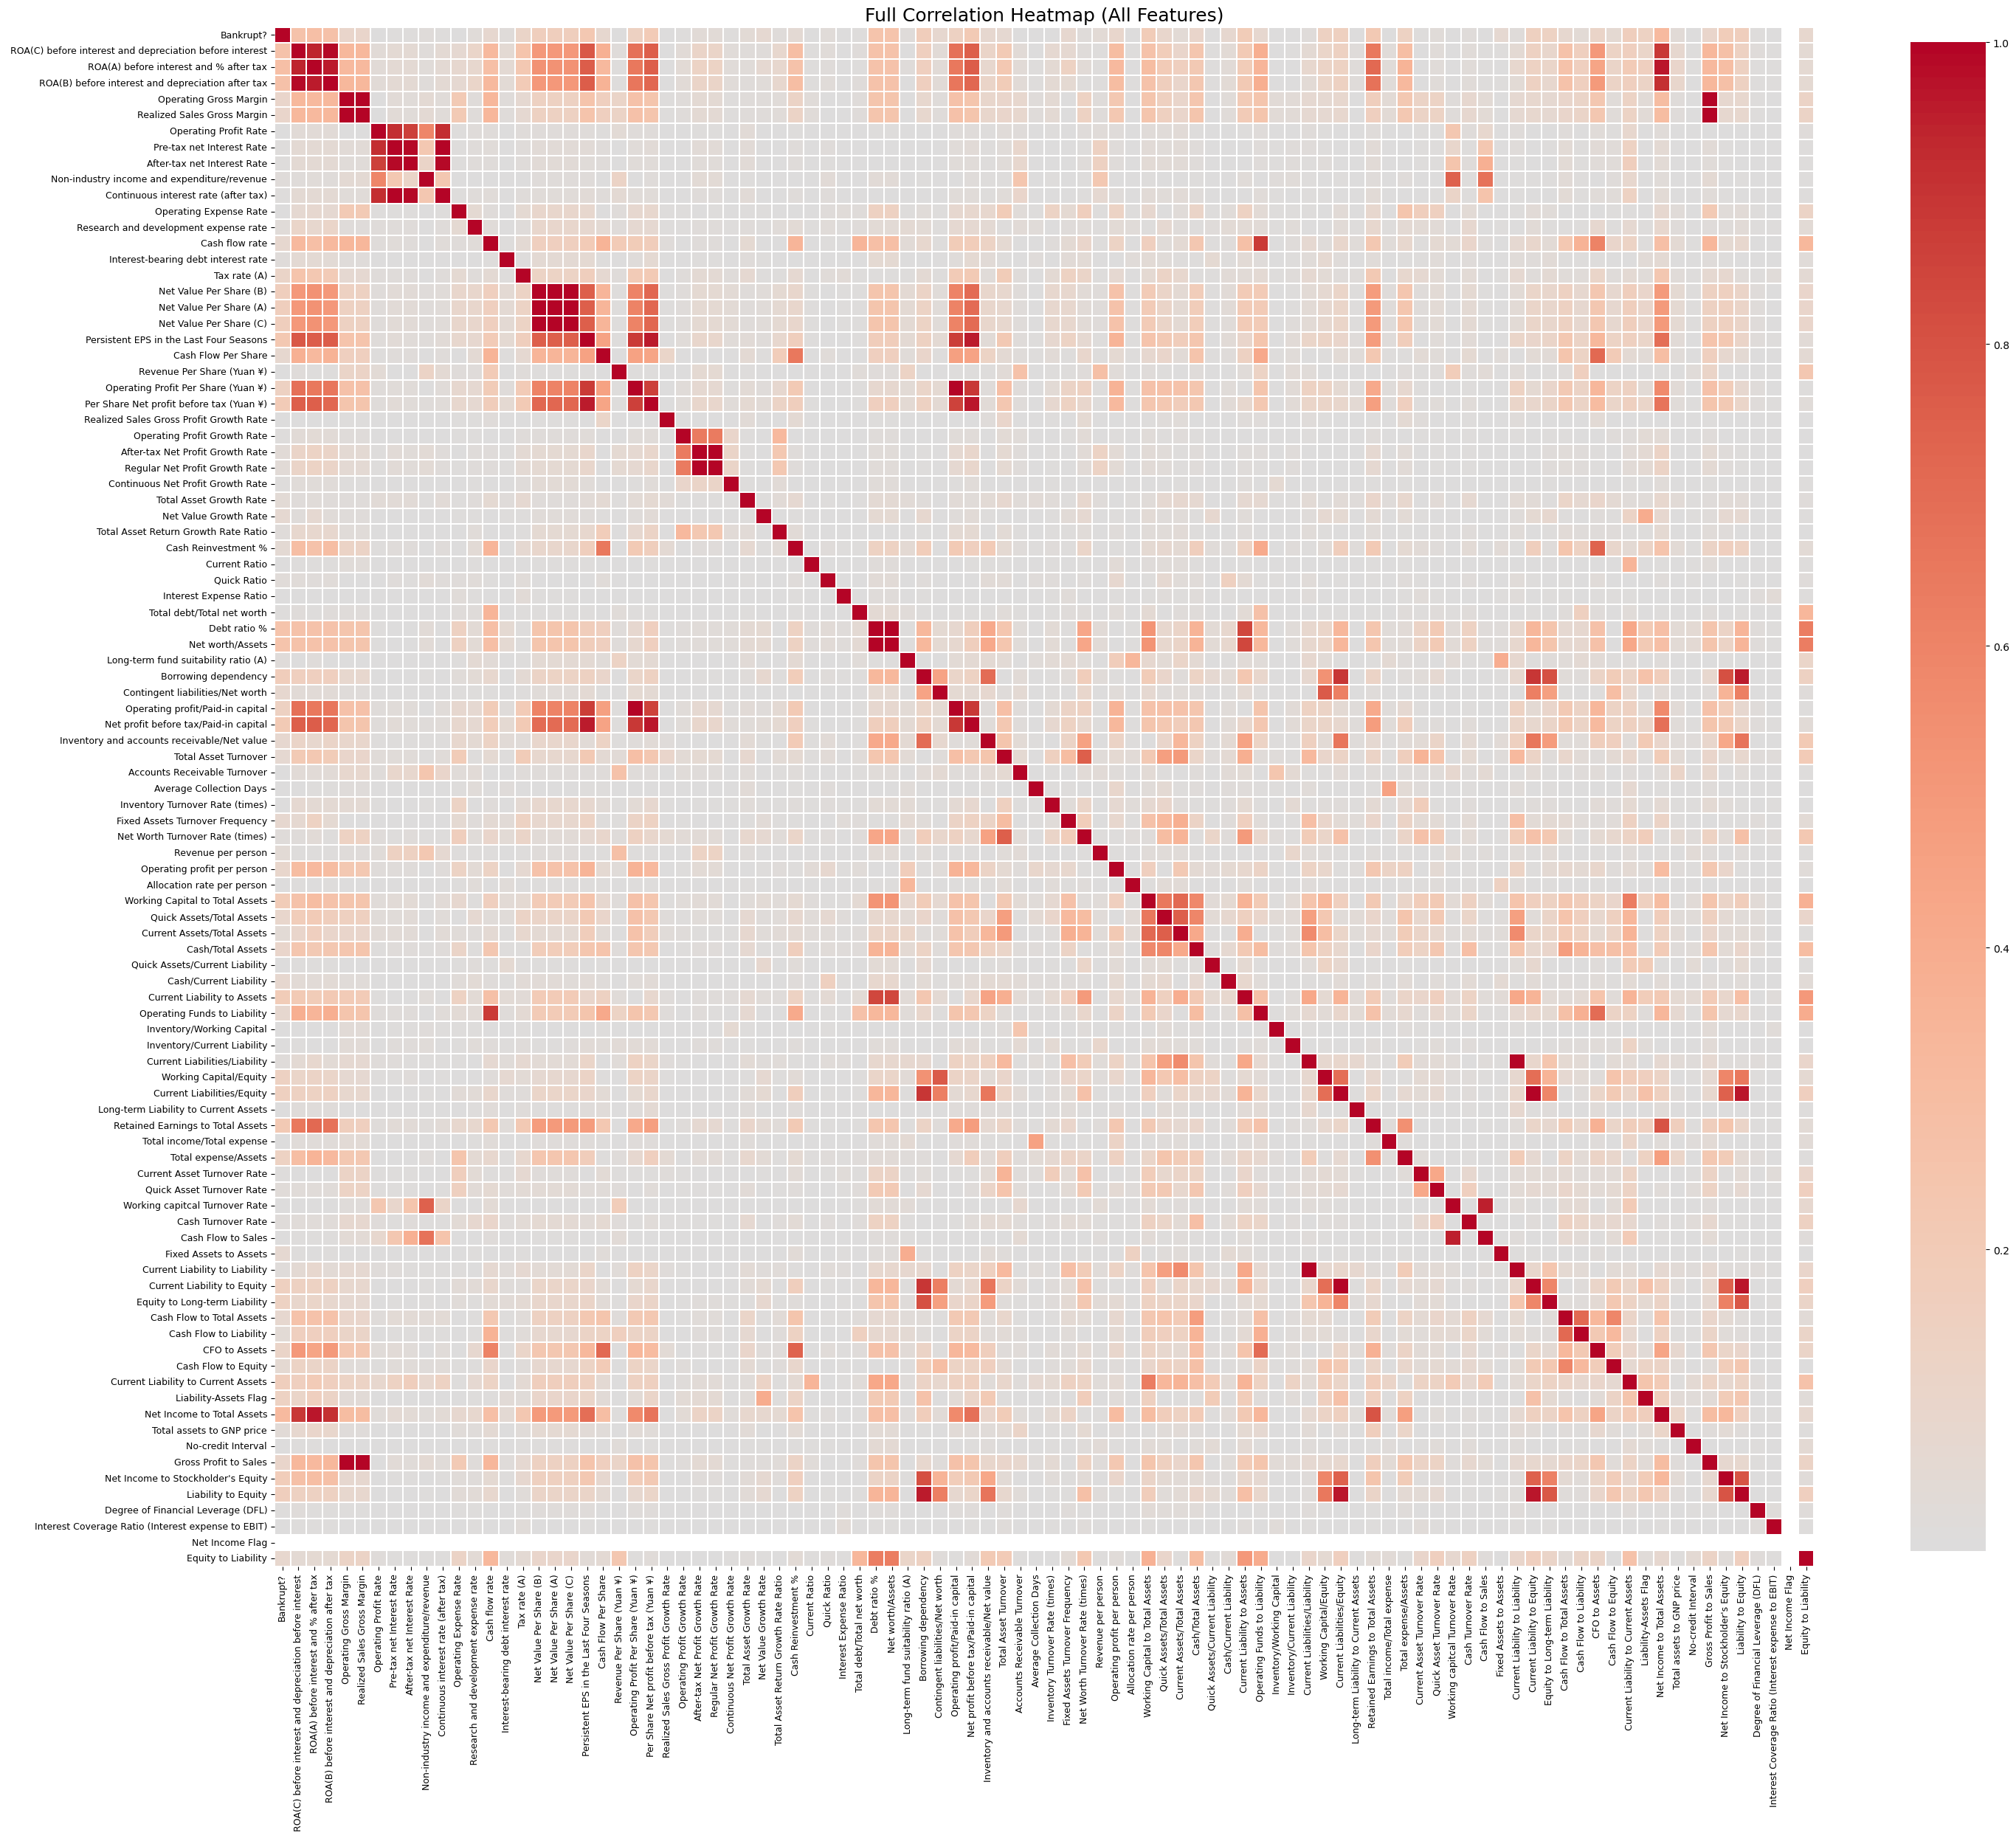

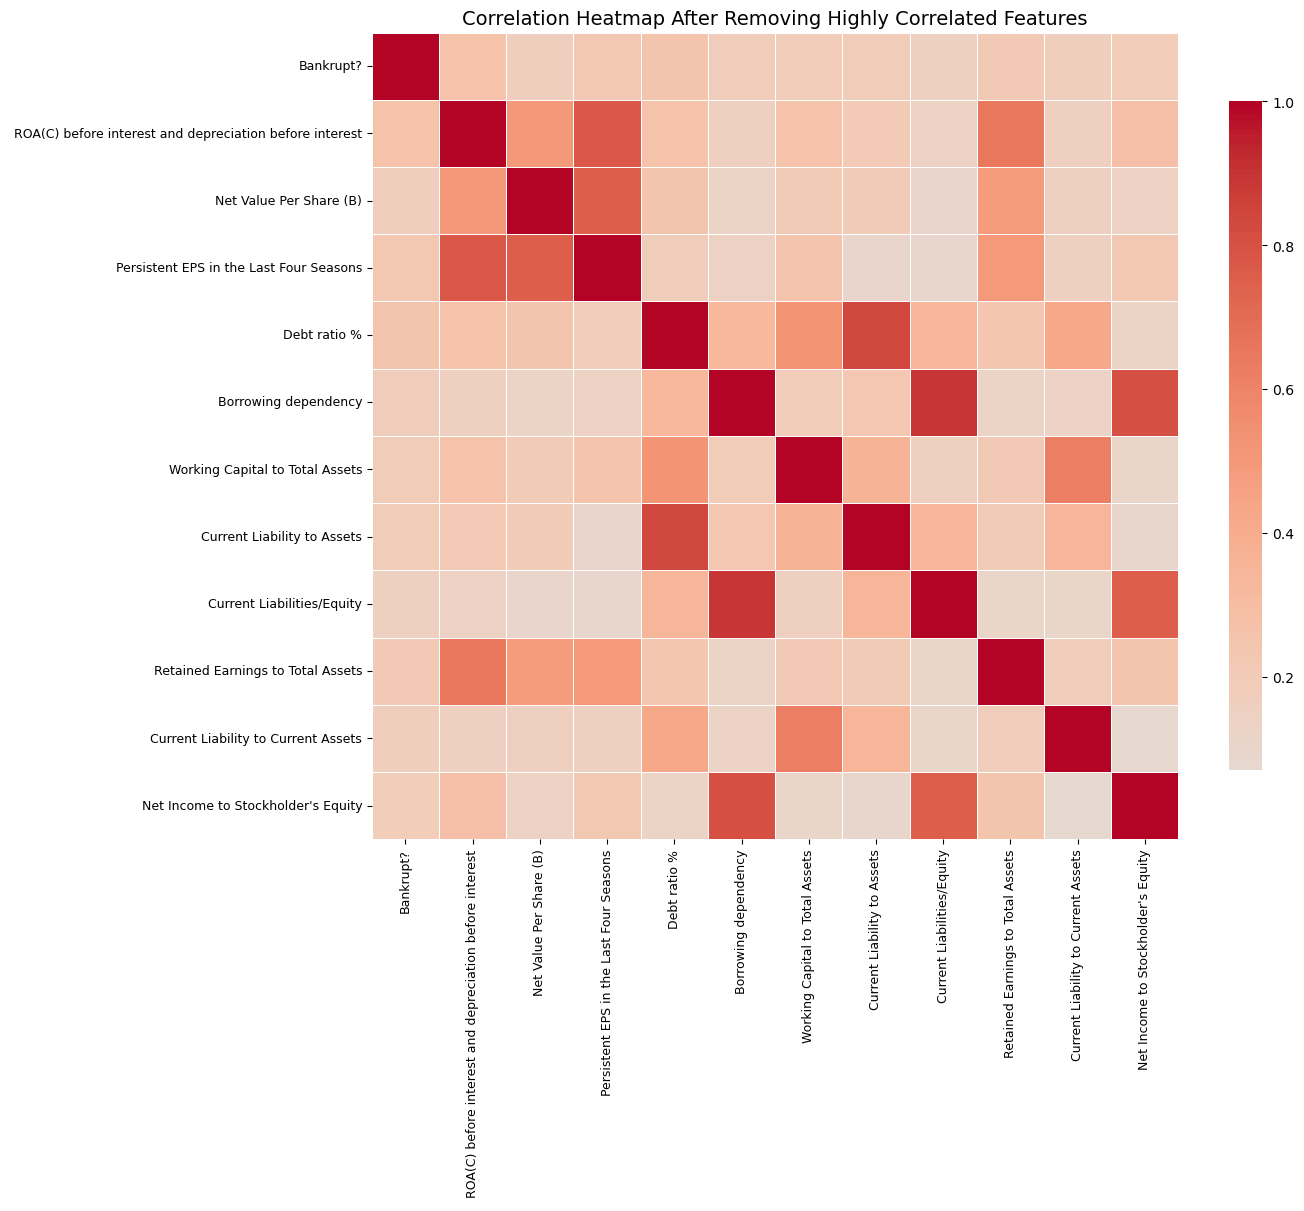

In [9]:
plt.figure(figsize=(30, 28))  # BIG figure

sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.1,
    cbar_kws={"shrink": 0.8}
)

plt.title("Full Correlation Heatmap (All Features)", fontsize=18)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()

corr_after = df_clean.corr().abs()

plt.figure(figsize=(14, 12))

sns.heatmap(
    corr_after,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Heatmap After Removing Highly Correlated Features", fontsize=14)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()

Dropped NaN-correlation features: 0

Dropped weak-correlation features (0 < |r| < 0.15): 0

Remaining features (including target): 12
- Bankrupt?
-  ROA(C) before interest and depreciation before interest
-  Net Value Per Share (B)
-  Persistent EPS in the Last Four Seasons
-  Debt ratio %
-  Borrowing dependency
-  Working Capital to Total Assets
-  Current Liability to Assets
-  Current Liabilities/Equity
-  Retained Earnings to Total Assets
-  Current Liability to Current Assets
-  Net Income to Stockholder's Equity


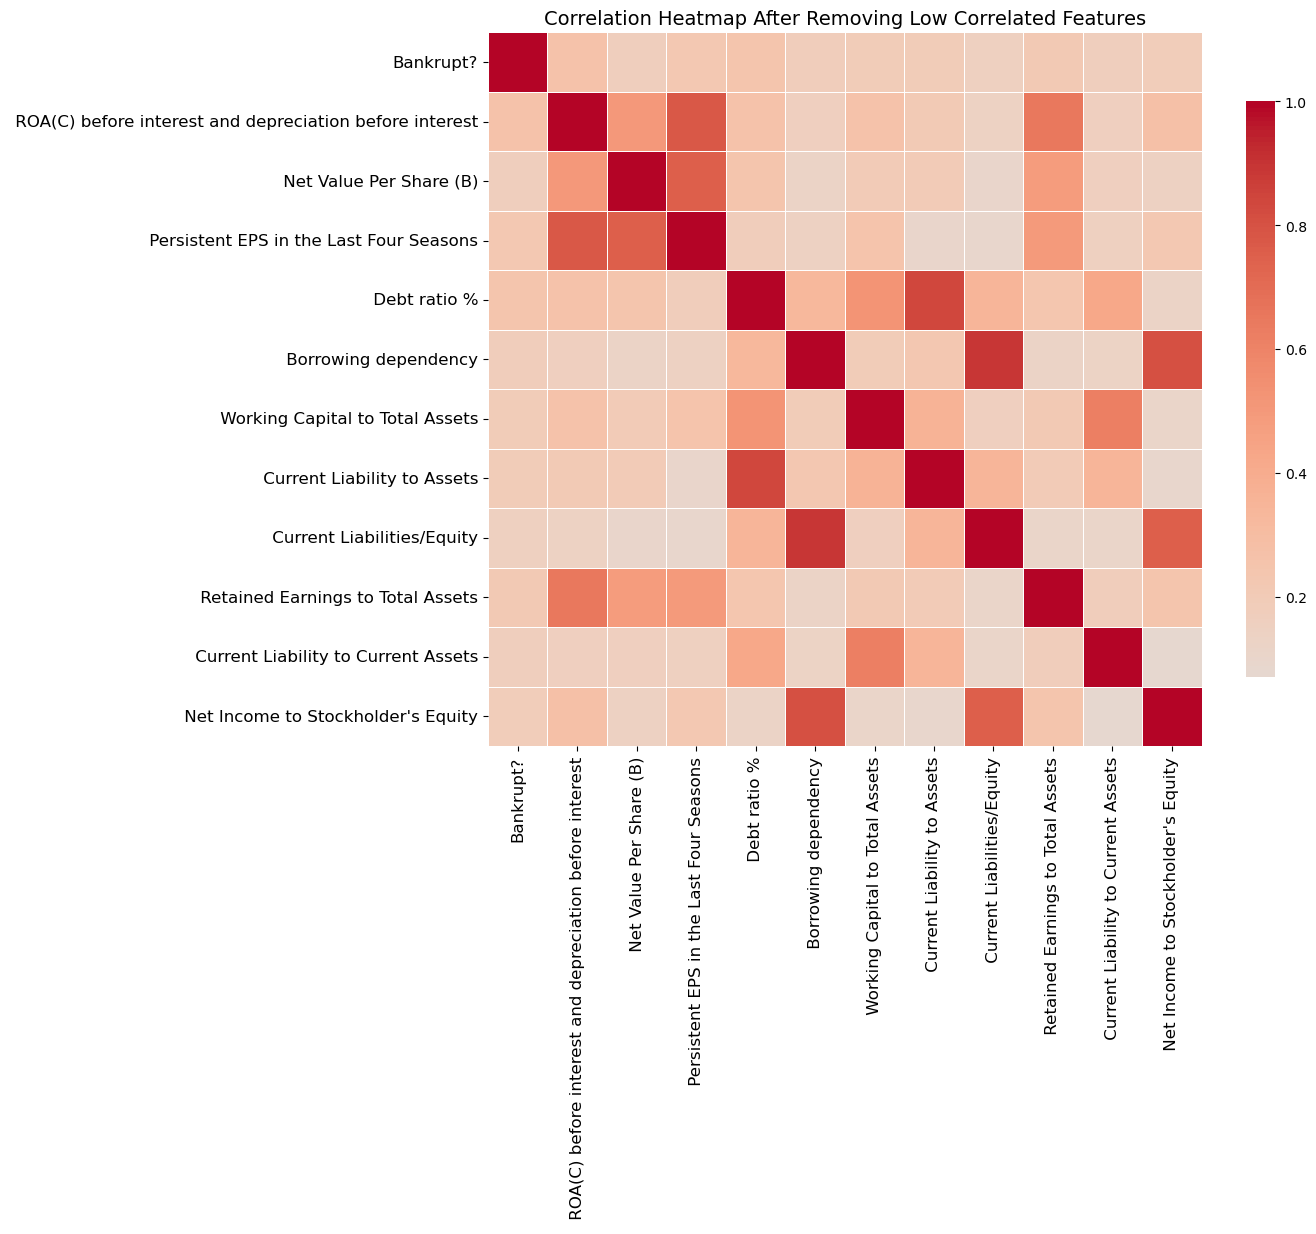

In [16]:
# ----------------------------
# 2. Remove features with LOW correlation with target 'Bankrupt?'
#    + Target-correlation heatmap
# ----------------------------

import matplotlib.pyplot as plt
import seaborn as sns

target = 'Bankrupt?'
low_corr_threshold = 0.15

# Compute absolute correlation with target
corr_with_target = df_clean.corr()[target].abs()

# ----------------------------
# 1) Drop features with NaN correlation
# ----------------------------
to_drop_nan = corr_with_target[corr_with_target.isna()].index.tolist()
df_clean = df_clean.drop(columns=to_drop_nan)

# ----------------------------
# 2) Drop weak but non-zero correlations (0 < |r| < threshold)
# ----------------------------
corr_with_target = corr_with_target.drop(labels=to_drop_nan)

to_drop_low = corr_with_target[(corr_with_target < low_corr_threshold)].index.tolist()

df_clean = df_clean.drop(columns=to_drop_low)

# ----------------------------
# Print results
# ----------------------------
print(f"Dropped NaN-correlation features: {len(to_drop_nan)}")
for col in to_drop_nan:
    print(f"- {col}")

print(f"\nDropped weak-correlation features (0 < |r| < {low_corr_threshold}): {len(to_drop_low)}")
for col in to_drop_low:
    print(f"- {col}")

print(f"\nRemaining features (including target): {df_clean.shape[1]}")
for col in df_clean:
    print(f"- {col}")
# ----------------------------
# Target-correlation heatmap (AFTER dropping low-corr features)
# ----------------------------
corr_after = df_clean.corr().abs()

plt.figure(figsize=(14, 12))

sns.heatmap(
    corr_after,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Heatmap After Removing Low Correlated Features", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [15]:
summary_df = (corr_with_target[final_features].sort_values(ascending=False).reset_index() )

summary_df.columns = ["Feature", "Correlation"]

summary_df


,Feature,Correlation
0,ROA(C) before interest and depreciation befor...,0.260807
1,Debt ratio %,0.250161
2,Persistent EPS in the Last Four Seasons,0.219560
3,Retained Earnings to Total Assets,0.217779
4,Current Liability to Assets,0.194494
5,Working Capital to Total Assets,0.193083
6,Net Income to Stockholder's Equity,0.180987
7,Borrowing dependency,0.176543
8,Current Liability to Current Assets,0.171306
9,Net Value Per Share (B),0.165399


In [21]:
print(f"\nFinal dataset shape: {df_clean.shape}")
df_clean.head(10)


Final dataset shape: (6819, 12)


,Bankrupt?,ROA(C) before interest and depreciation before interest,Net Value Per Share (B),Persistent EPS in the Last Four Seasons,Debt ratio %,Borrowing dependency,Working Capital to Total Assets,Current Liability to Assets,Current Liabilities/Equity,Retained Earnings to Total Assets,Current Liability to Current Assets,Net Income to Stockholder's Equity
0,1,0.370594,0.147950,0.169141,0.207576,0.390284,0.672775,0.147308,0.339077,0.903225,0.118250,0.827890
1,1,0.464291,0.182251,0.208944,0.171176,0.376760,0.751111,0.056963,0.329740,0.931065,0.047775,0.839969
2,1,0.426071,0.177911,0.180581,0.207516,0.379093,0.829502,0.098162,0.334777,0.909903,0.025346,0.836774
3,1,0.399844,0.154187,0.193722,0.151465,0.379743,0.725754,0.098715,0.331509,0.906902,0.067250,0.834697
4,1,0.465022,0.167502,0.212537,0.106509,0.375025,0.751822,0.110195,0.330726,0.913850,0.047725,0.839973
5,1,0.388680,0.155577,0.174435,0.180427,0.381448,0.686729,0.139002,0.335534,0.903041,0.099522,0.829939
6,0,0.390923,0.158822,0.161482,0.216102,0.384999,0.729416,0.115920,0.337392,0.911441,0.060765,0.829980
7,0,0.508361,0.176984,0.225206,0.108202,0.374219,0.797005,0.087042,0.329804,0.935449,0.030201,0.841459
8,0,0.488519,0.184189,0.218398,0.058591,0.370253,0.813738,0.058060,0.328093,0.935200,0.021710,0.840487
9,0,0.495686,0.177447,0.217831,0.121293,0.374509,0.825696,0.094563,0.330409,0.938290,0.025494,0.840688


In [30]:
df_clean.to_csv("clean_data.csv", index=False)
print("clean_data.csv")

clean_data.csv


In [22]:
target = 'Bankrupt?'
X = df_clean.drop(columns=[target])
y = df_clean[target]

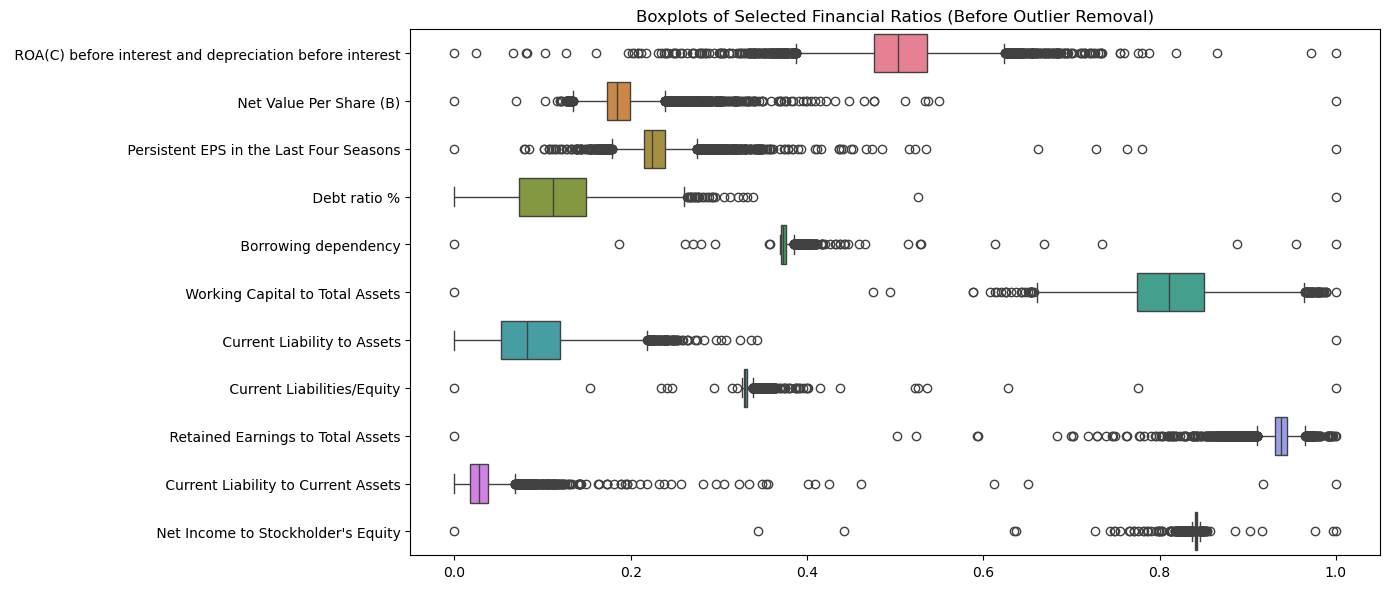

In [23]:
# ----------------------------
# Step 2: Visualize outliers BEFORE removal (boxplots)
# ----------------------------
plt.figure(figsize=(14, 6))
sns.boxplot(data=X, orient='h')
plt.title("Boxplots of Selected Financial Ratios (Before Outlier Removal)")
plt.tight_layout()
plt.show()

In [24]:
# ----------------------------
# Step 3: Define features to EXCLUDE from outlier removal
# (extreme values are meaningful for these ratios)
# ----------------------------
exclude_from_outlier = [
    ' Net Income to Stockholder\'s Equity',
    ' Current Liabilities/Equity',
    ' Borrowing dependency',
    ' Debt ratio %',
    ' Current Liability to Current Assets'
]

features_for_outlier = [
    col for col in X.columns
    if col not in exclude_from_outlier
]


In [25]:
# ----------------------------
# Step 4: IQR-based outlier detection
# ----------------------------
Q1 = X[features_for_outlier].quantile(0.25)
Q3 = X[features_for_outlier].quantile(0.75)
IQR = Q3 - Q1

# Mask rows that are NOT outliers
mask = ~(
    (X[features_for_outlier] < (Q1 - 1.5 * IQR)) |
    (X[features_for_outlier] > (Q3 + 1.5 * IQR))
).any(axis=1)

# Apply mask
df_no_outliers = df_clean[mask]

In [26]:
# ----------------------------
# Step 5: Report results
# ----------------------------
print("Outlier Removal Summary")
print("-" * 30)
print("Original dataset shape :", df_clean.shape)
print("After outlier removal  :", df_no_outliers.shape)
print("Rows removed           :", df_clean.shape[0] - df_no_outliers.shape[0])


Outlier Removal Summary
------------------------------
Original dataset shape : (6819, 12)
After outlier removal  : (5539, 12)
Rows removed           : 1280


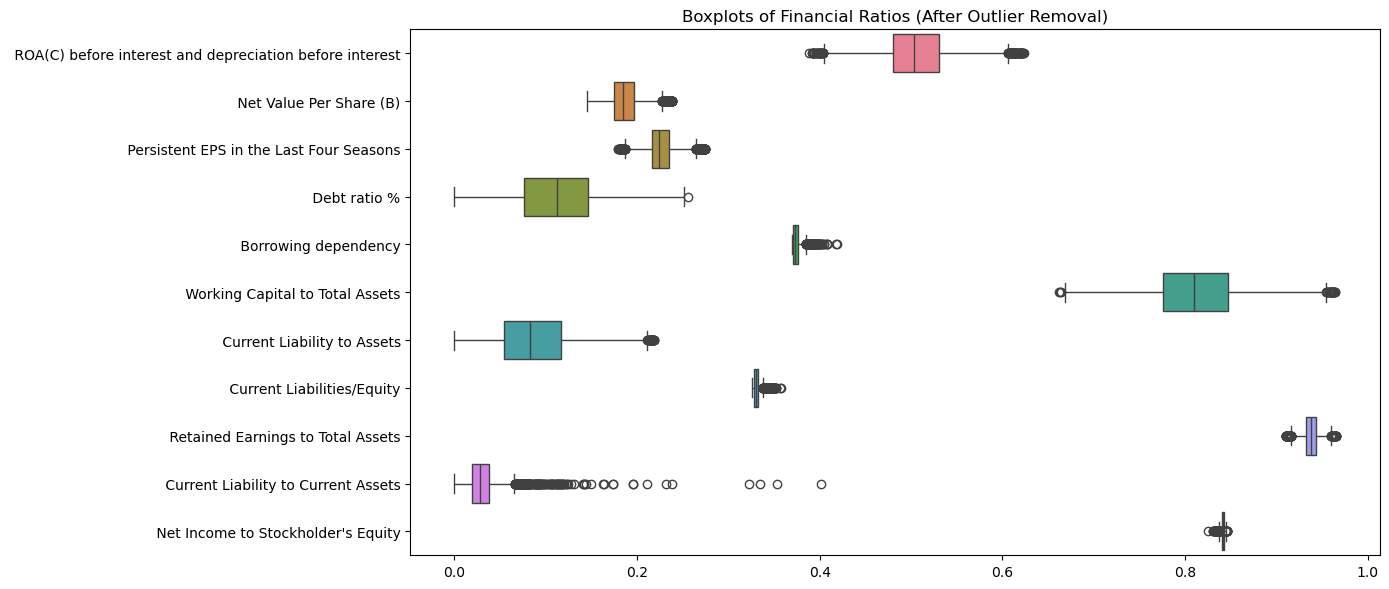

In [27]:
# ----------------------------
# Step 6: Visualize AFTER outlier removal
# ----------------------------
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_no_outliers.drop(columns=[target]), orient='h')
plt.title("Boxplots of Financial Ratios (After Outlier Removal)")
plt.tight_layout()
plt.show()

In [28]:
summary = (
    df_no_outliers[target]
    .value_counts()
    .rename(index={0: "Non-Bankrupt", 1: "Bankrupt"})
    .reset_index()
)

summary.columns = ["Class", "Count"]
summary

,Class,Count
0,Non-Bankrupt,5435
1,Bankrupt,104


In [31]:
df_no_outliers.to_csv("clean_outliers_data.csv", index=False)
print("clean_outliers_data.csv")

clean_outliers_data.csv
